# Tree Based Models

# Ensemble models

## Bagging

## Boosting

# Gradient Boosting

# XGBoost

# Implementation

In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# data
import yfinance as yf
from pathlib import Path

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams['figure.figsize'] = (20,10)
# plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_score,
)

# Classifier
from xgboost import XGBClassifier, plot_importance, to_graphviz

# metrics
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    auc,
)
from sklearn.metrics import classification_report, confusion_matrix

## Retrieve Data

In [2]:
# Get yahoo tickers for indian stocks
df_path = Path(".data/spy.csv")

if df_path.exists():
    # Read from file
    df = pd.read_csv(df_path, index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index, utc=True)
else:
    df_path.parent.mkdir(parents=True, exist_ok=True)

    df = yf.download('SPY',
        start = "2000-01-01",
        end = "2020-02-01",
        # period='20y',
    )

    # write data to file for future use
    df.to_csv(df_path)

# Display dataframe
pd.concat([df.head(), df.tail()])

[*********************100%***********************]  1 of 1 completed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00-05:00,148.250000,148.250000,143.875000,145.437500,94.262566,8164300
2000-01-04 00:00:00-05:00,143.531250,144.062500,139.640625,139.750000,90.576309,8089800
2000-01-05 00:00:00-05:00,139.937500,141.531250,137.250000,140.000000,90.738358,12177900
2000-01-06 00:00:00-05:00,139.625000,141.500000,137.750000,137.750000,89.280067,6227200
2000-01-07 00:00:00-05:00,140.312500,145.750000,140.062500,145.750000,94.465088,8066500
2020-01-27 00:00:00-05:00,323.029999,325.119995,322.660004,323.500000,305.003601,84062500
2020-01-28 00:00:00-05:00,325.059998,327.850006,323.600006,326.890015,308.199799,63834000
2020-01-29 00:00:00-05:00,328.380005,328.630005,326.399994,326.619995,307.945190,53888900
2020-01-30 00:00:00-05:00,324.359985,327.910004,323.540009,327.679993,308.944580,75491800


In [3]:
df = df[['Adj Close']]

# Calculate returns
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
# Output first five values
df.head()

,Adj Close,Returns,Ret_1M
Date,,,
2000-01-03 00:00:00-05:00,94.262566,NaN,NaN
2000-01-04 00:00:00-05:00,90.576309,-0.039891,NaN
2000-01-05 00:00:00-05:00,90.738358,0.001787,NaN
2000-01-06 00:00:00-05:00,89.280067,-0.016202,NaN
2000-01-07 00:00:00-05:00,94.465088,0.056452,NaN


## EDA of Original dataset

In [4]:
# Descriptive statistics
df.describe()

,Adj Close,Returns,Ret_1M
count,5052.000000,5051.000000,5032.000000
mean,127.581356,0.000231,0.004785
std,62.775576,0.011930,0.045355
min,51.386784,-0.103637,-0.348222
25%,82.764673,-0.004587,-0.016428
50%,100.630241,0.000642,0.011855
75%,170.268665,0.005774,0.031366
max,312.970459,0.135577,0.212051


## Cleaning & Imputation

In [5]:
# Check for missing values
df.isnull().sum()

Adj Close     0
Returns       1
Ret_1M       20
dtype: int64

## Feature Specification

In [6]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    df["Ret_" + str(r)] = df.Returns.rolling(r).sum()
    df["Std_" + str(r)] = df.Returns.rolling(r).std()
    features_list.append("Ret_" + str(r))
    features_list.append("Std_" + str(r))

# Drop NaN values
df.dropna(inplace=True)


## Target or Label Definition

In [7]:
# Define Target
df['Target'] = np.where(df['Adj Close'].shift(-1)>0.995 * df['Adj Close'],1,0)
# df = df[:-1]
# Check output
df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-29 00:00:00-05:00,98.258659,0.001034,0.090847,0.080964,0.016388,0.102198,0.017096,0.090847,0.016542,0.104483,...,0.015027,0.065879,0.015623,0.038944,0.015694,0.035948,0.015363,0.041519,0.017367,0
2000-03-30 00:00:00-05:00,96.613914,-0.016881,0.073289,0.018427,0.011734,0.056512,0.016967,0.073289,0.017210,0.107945,...,0.015315,0.056956,0.015801,0.013952,0.015853,0.031105,0.015451,0.064530,0.016697,1
2000-03-31 00:00:00-05:00,97.710457,0.011286,0.066025,0.023125,0.012035,0.073136,0.016873,0.066025,0.016954,0.122857,...,0.015243,0.072244,0.015850,0.040663,0.015763,0.052390,0.015448,0.074028,0.016749,1
2000-04-03 00:00:00-04:00,98.278976,0.005802,0.081617,0.034044,0.011779,0.089925,0.016292,0.081617,0.016677,0.107899,...,0.015233,0.109737,0.015024,0.048626,0.015772,0.044739,0.015368,0.096032,0.016601,0
2000-04-04 00:00:00-04:00,97.547966,-0.007466,0.093684,0.006264,0.010560,0.096767,0.015771,0.093684,0.015981,0.090837,...,0.015292,0.075494,0.014625,0.069912,0.015231,0.023786,0.015307,0.032114,0.014995,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27 00:00:00-05:00,305.003601,-0.016159,0.001733,-0.006808,0.007258,0.003375,0.006451,0.001733,0.006342,0.017065,...,0.005585,0.041325,0.005424,0.050762,0.005221,0.057158,0.005008,0.069678,0.004960,1
2020-01-28 00:00:00-05:00,308.199799,0.010425,0.012405,-0.003238,0.007742,0.009992,0.006923,0.012405,0.006748,0.023399,...,0.005761,0.055475,0.005557,0.060863,0.005387,0.067355,0.005164,0.077040,0.005097,1
2020-01-29 00:00:00-05:00,307.945190,-0.000826,0.017107,-0.002538,0.007733,0.011981,0.006870,0.017107,0.006603,0.018198,...,0.005718,0.056259,0.005549,0.058582,0.005394,0.063018,0.005161,0.078881,0.005079,1


In [8]:
# Convert to NumPy
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'],axis=1)
X.values

array([[ 0.08096369,  0.01638796,  0.10219757, ...,  0.01536323,
         0.04151924,  0.01736738],
       [ 0.0184269 ,  0.01173368,  0.05651195, ...,  0.01545095,
         0.06453008,  0.01669714],
       [ 0.02312483,  0.01203496,  0.07313595, ...,  0.015448  ,
         0.07402841,  0.01674895],
       ...,
       [-0.00253802,  0.00773287,  0.01198131, ...,  0.00516136,
         0.07888064,  0.00507863],
       [-0.00155537,  0.00777446,  0.00990597, ...,  0.00516609,
         0.07289941,  0.00497851],
       [-0.02816396,  0.00901896, -0.0151766 , ...,  0.00578392,
         0.05056487,  0.00556628]])

In [9]:
# Define label or target
y = df['Target']
y

Date
2000-03-29 00:00:00-05:00    0
2000-03-30 00:00:00-05:00    1
2000-03-31 00:00:00-05:00    1
2000-04-03 00:00:00-04:00    0
2000-04-04 00:00:00-04:00    0
                            ..
2020-01-27 00:00:00-05:00    1
2020-01-28 00:00:00-05:00    1
2020-01-29 00:00:00-05:00    1
2020-01-30 00:00:00-05:00    0
2020-01-31 00:00:00-05:00    0
Name: Target, Length: 4992, dtype: int64

In [10]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 3993, 999


# Base Model

## Fit Model

In [11]:
# Scale and fit the classifier model
model = XGBClassifier(verbosity = 0, silent=True, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

## Predict Model

In [12]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [13]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.9912, Test Accuracy: 0.7508


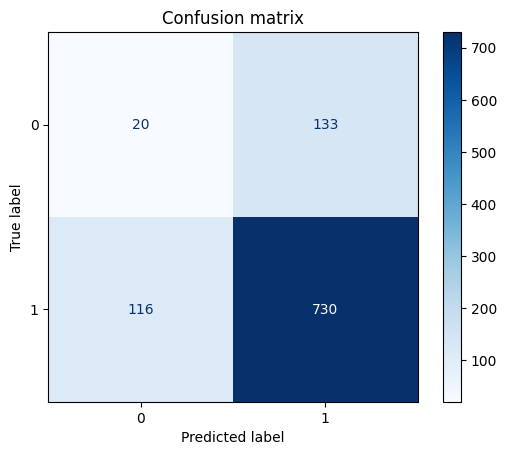

In [14]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, display_labels=model.classes_, cmap=plt.cm.Blues
)
disp.ax_.set_title("Confusion matrix")
plt.show()

In [15]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.13      0.14       153
           1       0.85      0.86      0.85       846

    accuracy                           0.75       999
   macro avg       0.50      0.50      0.50       999
weighted avg       0.74      0.75      0.74       999



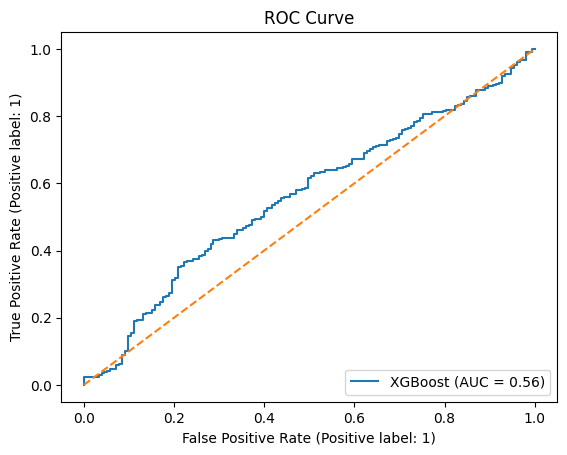

In [16]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(model, X_test, y_test, name="XGBoost")
disp_roc.ax_.set_title("ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.show()

# Hyper-parameter Tuning

## XGBoost’s hyper-parameter

## RandomizedSearch

In [17]:
# Timeseries CV 3-split
# tscv = TimeSeriesSplit(n_splits=4, gap=1) # sklearn 1.0
# for train, test in tscv.split(X):
# print(train, test)

In [18]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [19]:
# Get params list
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [20]:
# Hyper parameter optimization
param_grid = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
}

In [21]:
# perform random search
rs = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='f1', cv=tscv,verbose=0)
rs.fit(X_train, y_train, verbose=0)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [22]:
# best parameters
rs.best_params_

{'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [23]:
# best score
rs.best_score_

0.8305289138639191

# Tuned Model

In [24]:
# Refit the XGB Classifier with the best params
cls = XGBClassifier(**rs.best_params_)
cls.fit(X_train, y_train,
eval_set=[(X_train, y_train), (X_test, y_test)],
# eval_metric='logloss',
verbose=True)

[0]	validation_0-logloss:0.68023	validation_1-logloss:0.67322
[1]	validation_0-logloss:0.66854	validation_1-logloss:0.65532
[2]	validation_0-logloss:0.65785	validation_1-logloss:0.63881
[3]	validation_0-logloss:0.64812	validation_1-logloss:0.62332
[4]	validation_0-logloss:0.63936	validation_1-logloss:0.60950
[5]	validation_0-logloss:0.63123	validation_1-logloss:0.59634
[6]	validation_0-logloss:0.62376	validation_1-logloss:0.58435
[7]	validation_0-logloss:0.61700	validation_1-logloss:0.57340
[8]	validation_0-logloss:0.61078	validation_1-logloss:0.56322
[9]	validation_0-logloss:0.60505	validation_1-logloss:0.55371
[10]	validation_0-logloss:0.59975	validation_1-logloss:0.54530
[11]	validation_0-logloss:0.59487	validation_1-logloss:0.53714
[12]	validation_0-logloss:0.59050	validation_1-logloss:0.53008
[13]	validation_0-logloss:0.58639	validation_1-logloss:0.52326


[14]	validation_0-logloss:0.58274	validation_1-logloss:0.51725
[15]	validation_0-logloss:0.57942	validation_1-logloss:0.51092
[16]	validation_0-logloss:0.57622	validation_1-logloss:0.50570
[17]	validation_0-logloss:0.57328	validation_1-logloss:0.50092
[18]	validation_0-logloss:0.57058	validation_1-logloss:0.49658
[19]	validation_0-logloss:0.56811	validation_1-logloss:0.49237
[20]	validation_0-logloss:0.56577	validation_1-logloss:0.48833
[21]	validation_0-logloss:0.56362	validation_1-logloss:0.48454
[22]	validation_0-logloss:0.56169	validation_1-logloss:0.48094
[23]	validation_0-logloss:0.55980	validation_1-logloss:0.47733
[24]	validation_0-logloss:0.55804	validation_1-logloss:0.47423
[25]	validation_0-logloss:0.55641	validation_1-logloss:0.47146
[26]	validation_0-logloss:0.55495	validation_1-logloss:0.46874
[27]	validation_0-logloss:0.55349	validation_1-logloss:0.46609
[28]	validation_0-logloss:0.55220	validation_1-logloss:0.46313
[29]	validation_0-logloss:0.55108	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
# Return the evaluation results
# evals_result = cls.evals_result()
# evals_result

In [26]:
# Cross validation score
score = cross_val_score(cls,X_train,y_train,cv=tscv)
print(f'Mean CV Score : {score.mean():0.4}')

Mean CV Score : 0.7302


## Feature Importance

Text(0.5, 1.0, 'Features Importance')

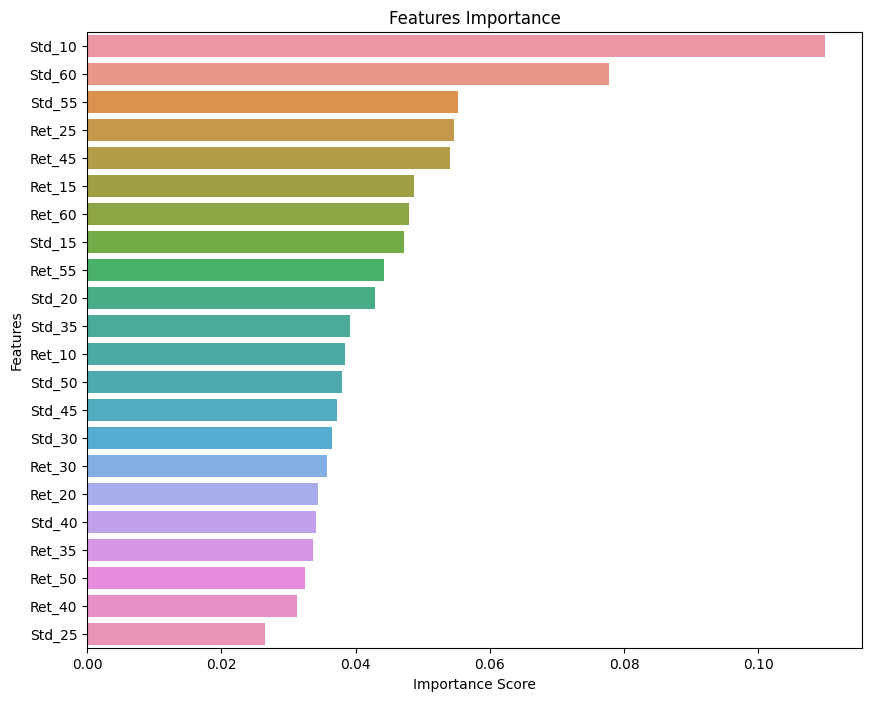

In [27]:
# Plot feature importance

fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

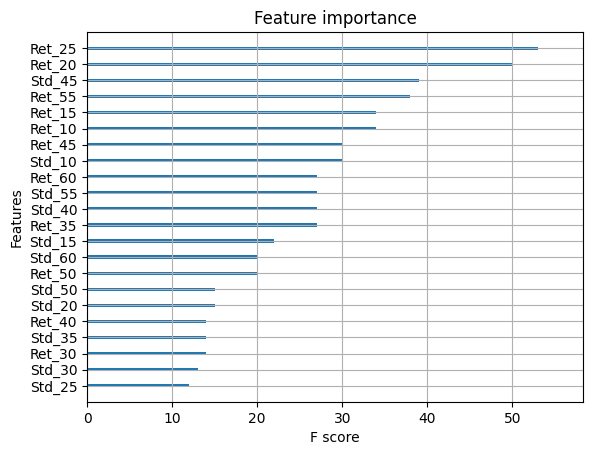

In [29]:
# feature importance_type = 'gain'
plot_importance(cls, importance_type='weight', show_values=False)

## Shap Values

In [30]:
import shap
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

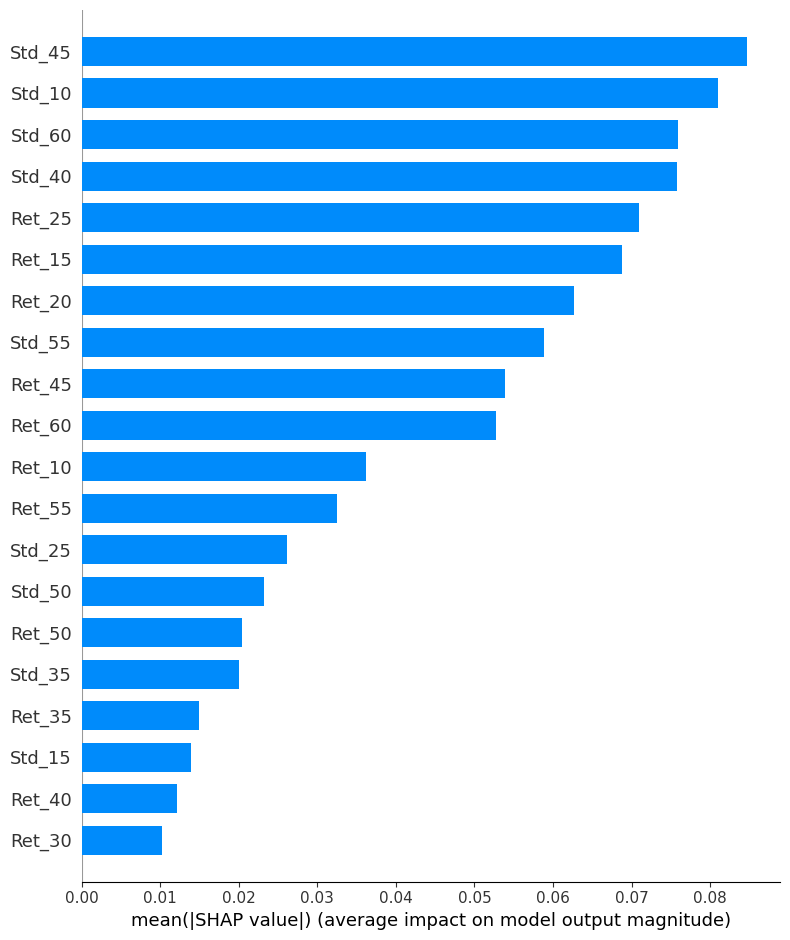

In [31]:
# future importance summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

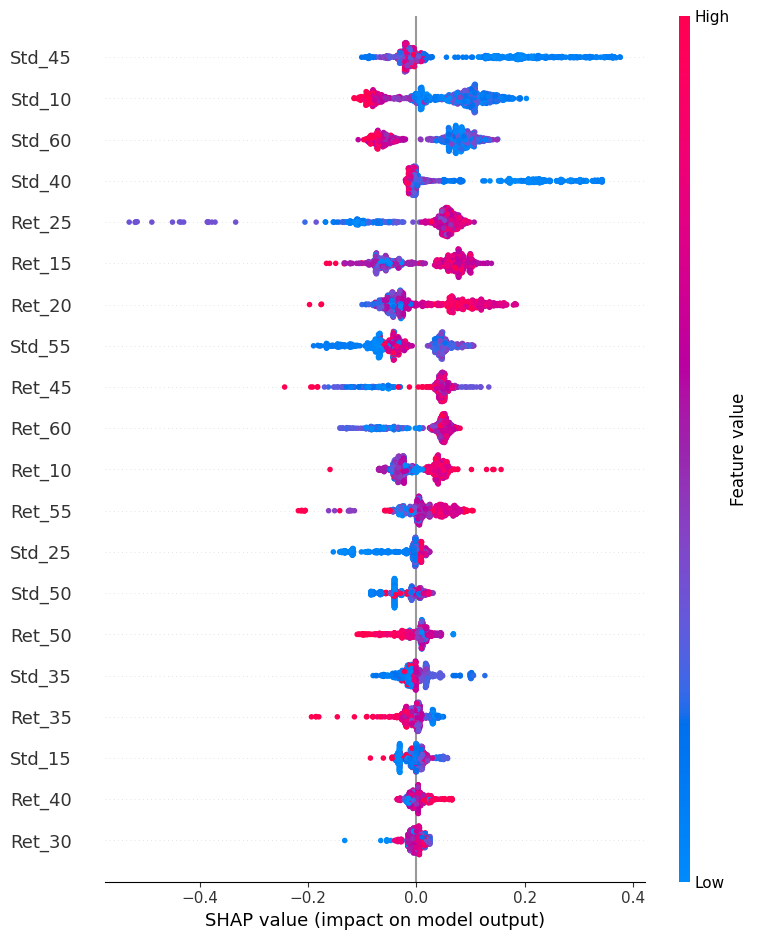

In [32]:
# interpretation plot
shap.summary_plot(shap_values, X_test)

## Plot Tree

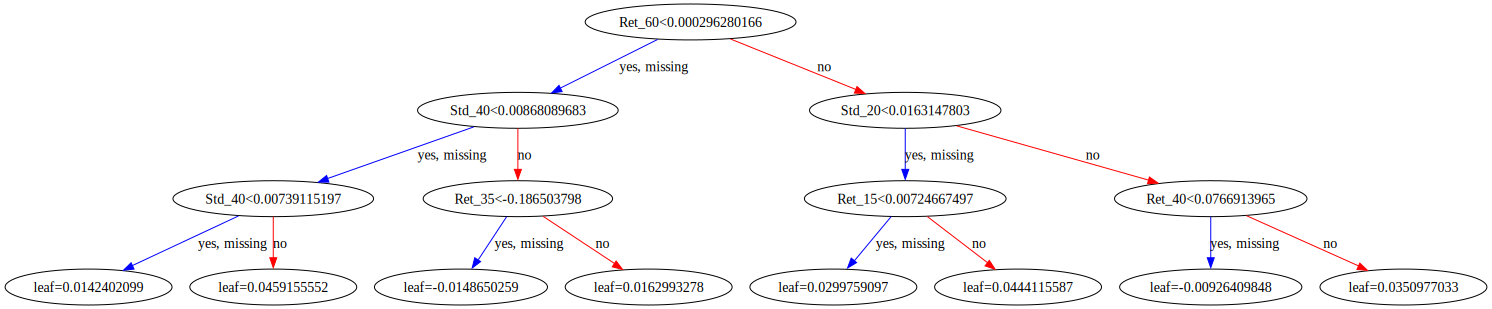

In [33]:
## Tree Visualization
# change tree number to see the corresponding plot
to_graphviz(cls, num_trees=10, rankdir='UT')

## Predict Model


 Training Accuracy 	: 0.7466 
 Test Accuracy 		:0.8468


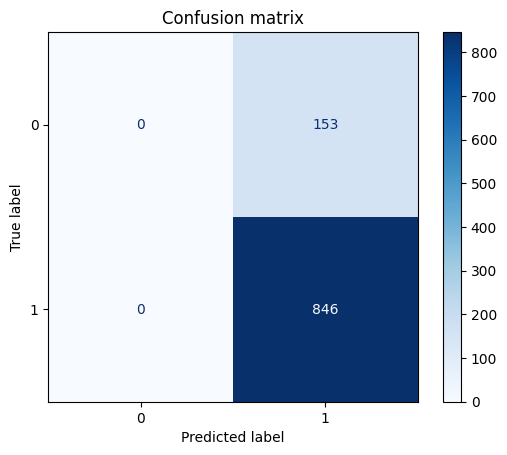

In [34]:
# Predicting the test dataset
y_pred = cls.predict(X_test)
# Measure Accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f"\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t:{acc_test :0.4}")

# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    cls, X_test, y_test, display_labels=model.classes_, cmap=plt.cm.Blues
)
disp.ax_.set_title("Confusion matrix")
plt.show()

In [35]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.85      1.00      0.92       846

    accuracy                           0.85       999
   macro avg       0.42      0.50      0.46       999
weighted avg       0.72      0.85      0.78       999



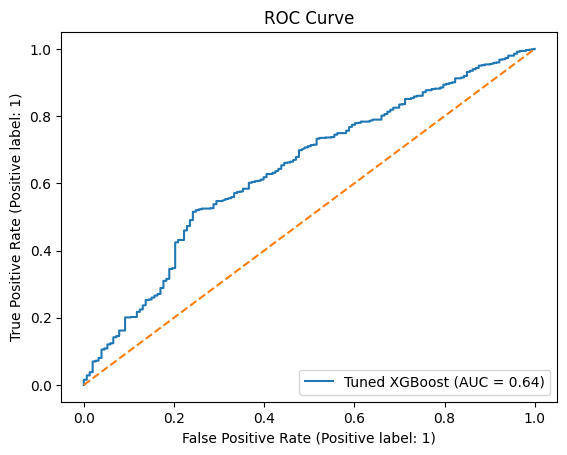

In [36]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(cls, X_test, y_test, name="Tuned XGBoost")
disp_roc.ax_.set_title("ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.show()